# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import time
import os
import matplotlib.pyplot as plt

# Loading the data and some useful stats

In [2]:
directory = "MAL Dataset/a5000u100k"

In [3]:
mal_dataset = pd.read_csv(os.path.join(directory, "ratings.csv"))
nusers = mal_dataset['uid'].nunique()
nanime = mal_dataset['aid'].nunique()
sparsity = len(mal_dataset) / (nusers * nanime)
nusers, nanime, sparsity

(100000, 5000, 0.044789772)

# Some hyperparameters
latent_features: Latent dimension for anime and user matrices<br>
lambd: Regularization term weight<br>
And the rest are self explanatory

In [4]:
latent_features = 10
learning_rate = 1e-3
batch_size = 1024
epochs = 10
lambd = 2e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.cuda.get_device_name(torch.cuda.current_device())

(device(type='cuda'), 'NVIDIA GeForce RTX 3070 Laptop GPU')

# Constructing the sparse matrix
A (nanime x nusers) dimension matrix which contains ratings in sparse locations. Note that this is on the CPU RAM and not GPU RAM because of memory constraints

In [5]:
ratings_sparse = torch.sparse_coo_tensor(torch.tensor(mal_dataset[['aid', 'uid']].values).T, torch.tensor(mal_dataset['my_score'].values).reshape(-1), (nanime, nusers))
ratings_dense = ratings_sparse.to_dense()
ratings_dense.shape

torch.Size([5000, 100000])

# Mask
This is so that when we generate the predicted ratings, we can element-wise multiply that with this matrix, in order to compute the RMSE against our existing ratings. This trick helps us vectorize everything rather than running a for loop.
Again, this is not on the VRAM because of memory constraints.<br>

In [6]:
mask = torch.where(ratings_dense>0, 1, 0)

# Feature scaling
A neat little preprocessing step that's proven to speed up learning. It also appropriately deals with certain users who've rated very few anime

In [7]:
a_avs = torch.sum(ratings_dense, dim=1, keepdim=True) / torch.count_nonzero(ratings_dense, dim=1).reshape(-1,1)
ratings_dense = mask * (ratings_dense - a_avs)

a_stds = torch.sum(torch.square(ratings_dense), dim=1, keepdim=True) / (1e-3 + torch.count_nonzero(ratings_dense, dim=1).reshape(-1,1))
a_stds = torch.sqrt(a_stds)

ratings_dense = ratings_dense / a_stds

In [8]:
# These 1D matrices are not that big, so GPU time (if available ofc)
a_stds = a_stds.to(device)
a_avs = a_avs.to(device)

In [9]:
# Just checking if std is 1
torch.sum(torch.square(ratings_dense), dim=1, keepdim=True) / torch.count_nonzero(ratings_dense, dim=1).reshape(-1,1)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        ...,
        [1.0000],
        [1.0000],
        [1.0000]])

In [10]:
# and mean is 0 for all anime
torch.sum(ratings_dense, dim=1, keepdim=True) / torch.count_nonzero(ratings_dense, dim=1).reshape(-1,1)

tensor([[-2.7682e-07],
        [ 3.4735e-07],
        [-1.1527e-07],
        ...,
        [ 1.3543e-07],
        [ 7.6447e-09],
        [ 1.2328e-07]])

# Visualization
Let's see the distributions before and after
#### Before:

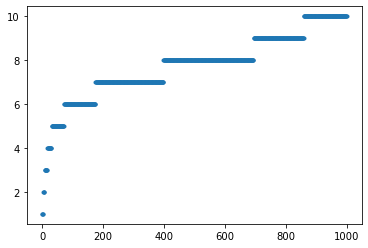

In [11]:
plt.plot(np.sort(np.random.choice(mal_dataset['my_score'].to_numpy(), 1000)), '.')

#### After:

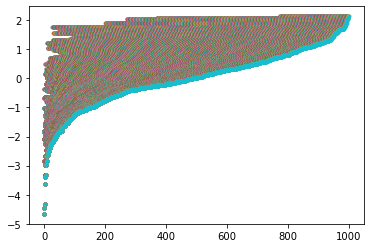

In [12]:
nonzero = torch.nonzero(ratings_dense).numpy()
nonzero_indices = np.random.choice(nonzero.shape[0], 1000, replace=False)
nonzero = nonzero[nonzero_indices]
agg = []
for i, j in nonzero:
    agg.append(float(ratings_dense[i,j]))
    plt.plot(sorted(agg), '.')

Works. If we wanted to feature-scale the matrix along each user instead, we can run the cell below but I think scaling per anime makes more sense.

In [13]:
#user_avs = torch.sum(ratings_dense, dim=0, keepdim=True) / torch.count_nonzero(ratings_dense, dim=0).reshape(1,-1)
#ratings_dense = mask * (ratings_dense - user_avs)

#u_stds = torch.sum(torch.square(ratings_dense), dim=0, keepdim=True) / (1e-3 + torch.count_nonzero(ratings_dense, dim=0).reshape(1,-1))

#ratings_dense = ratings_dense / torch.sqrt(user_stds)

In [14]:
# Test train split
train, test = np.split(mal_dataset[['uid', 'aid']].sample(frac=1), [int(0.9*len(mal_dataset))])
train_len = len(train)
test_len = len(test)
total_len = train_len + test_len
train_len, test_len, total_len

(20155397, 2239489, 22394886)

# Test and train masks
Just as the names suggest, masks for computing the test and train RMSE's vectorized-ly.<br>
However making the mask itself is the one thing I couldn't vectorize. After wracking my brain and searching the PyTorch docs for a couple hours I gave up and settled for a for loop. A stain in the otherwise perfectly-vectorized notebook, sure, but at least I'm running it only once.

In [15]:
# Masks for test and train datasets
mask_test = torch.zeros_like(ratings_dense)
for index, row in test[['uid', 'aid']].iterrows():
    mask_test[row['aid'], row['uid']] = 1
    
mask_train = mask - mask_test
torch.count_nonzero(mask_test)

tensor(2239489)

# Initializing the weights
Only these matrices, which contain our learnable parameters, are initialized on the GPU for performance.<br>
Oh, and of course, the optimizer. Why bother implementing it yourself when you're already committed to using PyTorch

In [16]:
user_matrix = torch.randn(latent_features, nusers, requires_grad=True, device=device)
anime_matrix = torch.randn(nanime, latent_features, requires_grad=True, device=device)

In [17]:
optimizer = torch.optim.Adam([
    {'params': user_matrix},
    {'params': anime_matrix}
], lr=learning_rate)

In [18]:
# For plotting
total_rmse_history = []
test_rmse_history = []
train_rmse_history = []

# Partitioning
Remember how we created the ratings and mask matrices on the CPU? Well, we need to send them over to the GPU to compute the RMSE's. We certainly don't want to do it in the CPU.<br>
The GPU only has so much memory, so we need to split up the big matrices and compute the RMSE by aggregating the result from each partition.

In [19]:
partitions = 10

# The training loop
### Batching
This is the part which is relatively unique and required a bit of thinking. We need (approximately) batch_size number of ratings per batch, and these ratings need to be organized in a matrix similar to the sparse matrix in order for the loss computation to be vectorized.<br>
The "chunk" variable in the data-loader contains a pandas dataframe with 3 columns and batch_size rows. We construct a diagonal matrix of size batch_size x batch_size where the rows are anime and columns are users, and the actual elements are ratings. This is not quite similar to the original ratings matrix, as there may be duplicate user/anime columns/rows, but this effectively solves the vectorization problem. PyTorch's autograd takes care of the rest.
### Loss
This is just a simple matrix norm of the difference between masked predictions and existing ratings. Added to it is a simple regularization term.
### Testing
This is where our earlier computed mask, ratings matrix and partitions come into play. Using these we compute a slightly different loss metric compared to while training, which is the RMSE. It's a commonly used metric in recommender systems that was also used in the [Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest. Regularization is not taken into account here.<br>
### Performance profiling
[Robert Kern's line_profiler](https://github.com/pyutils/line_profiler) is used to time each line and identify bottlenecks. In my case, I was using PyTorch's dataloader earlier and that was taking up about 87% of the total time per loop just to fetch data. Increasing the num_workers parameters led to crashes due to windows restricting multithreading or something (I'm not very knowledgeable in the matter, check https://github.com/pytorch/pytorch/issues/12831). After fruitless efforts to remedy that I just ended up using good ol' numpy. Now my "bottleneck" is the batchwise loss computation and backpropagation, which I'll leave to PyTorch and Nvidia to optimize :)

P.S. You might notice a lot of commented debugging statements in the middle, that's to be expected cause this is my first time using PyTorch and messing around with CUDA :]

In [20]:
%load_ext line_profiler
def training_loop():
    for epoch in range(epochs):
        print("Epoch " + str(epoch))
        for i, chunk in enumerate(np.array_split(train, int(len(train)/batch_size))):
            if i%5000 == 0:
                print(str(i) + " iterations, " + str(len(chunk) * i) + " samples processed")
                te, tr, to = rmse()
                print("Test RMSE: " + str(te))
                print("Train RMSE: " + str(tr))
                print("Total RMSE: " + str(to))
                print("")
            
            optimizer.zero_grad()
            samples = torch.tensor(chunk.values)
#            print("Grad before backprop: " + str(float(torch.norm(anime_matrix.grad)))) if anime_matrix.grad is not None else print("Grad before backprop: None")
            mask_cuda = torch.diag(torch.ones(len(chunk), device=device))
            ratings_cuda = ratings_dense[samples[:,1], samples[:,0]].to(device)
            loss = torch.norm(mask_cuda * torch.matmul(anime_matrix[samples[:,1], :], user_matrix[:, samples[:,0]]) - ratings_cuda) + lambd * (torch.norm(anime_matrix[samples[:,1], :]) + torch.norm(user_matrix[:, samples[:,0]]))
            loss.backward()
#            print("Grad after backprop: " + str(float(torch.norm(anime_matrix.grad)))) if anime_matrix.grad is not None else print("Grad after backprop: None")
#            am = anime_matrix.clone().detach()
            optimizer.step()
            del mask_cuda
            del ratings_cuda
#            print("Difference after step: " + str(float(torch.sum(am-anime_matrix))))
#            print("")
#            time.sleep(5)

def rmse():
    test_rmse = 0
    train_rmse = 0
    preds = torch.matmul(anime_matrix, user_matrix) * a_stds + a_avs
    for n in range(partitions):
        a_start = int(nanime*n/partitions)
        a_end = int(nanime*(n+1)/partitions)
        u_start = int(nusers*n/partitions)
        u_end = int(nusers*(n+1)/partitions)
        ratings_c = ratings_dense[a_start:a_end, u_start:u_end].to(device)
        mask_c_test = mask_test[a_start:a_end, u_start:u_end].to(device)
        mask_c_train = mask_train[a_start:a_end, u_start:u_end].to(device)
        pred_partition = preds[a_start:a_end, u_start:u_end]
        a_stds_part = a_stds[a_start:a_end]
        a_avs_part = a_avs[a_start:a_end]
        test_rmse += float(torch.sum(torch.square(mask_c_test * pred_partition - mask_c_test * (ratings_c * a_stds_part + a_avs_part))))
        train_rmse += float(torch.sum(torch.square(mask_c_train * pred_partition - mask_c_train * (ratings_c * a_stds_part + a_avs_part))))
        del ratings_c
        del mask_c_test
        del mask_c_train
    total_rmse = test_rmse + train_rmse
    
    test_rmse = np.sqrt(test_rmse/test_len)
    train_rmse = np.sqrt(train_rmse/train_len)
    total_rmse = np.sqrt(total_rmse/total_len)
    
    test_rmse_history.append(test_rmse)
    train_rmse_history.append(train_rmse)
    total_rmse_history.append(total_rmse)
    del preds
    
    return test_rmse, train_rmse, total_rmse

In [21]:
%lprun -f training_loop training_loop()

Epoch 0
0 iterations, 0 samples processed
Test RMSE: 1.5985299358928284
Train RMSE: 1.5966822385655943
Total RMSE: 1.5968671045380565

5000 iterations, 5120000 samples processed
Test RMSE: 0.7688783919528421
Train RMSE: 0.7635515342986843
Total RMSE: 0.7640858913001128

10000 iterations, 10240000 samples processed
Test RMSE: 0.5534148610517706
Train RMSE: 0.5485130462839347
Total RMSE: 0.5490051973242923

15000 iterations, 15360000 samples processed
Test RMSE: 0.501136064676306
Train RMSE: 0.4975665924647292
Total RMSE: 0.49792469123238264

Epoch 1
0 iterations, 0 samples processed
Test RMSE: 0.4815163688379967
Train RMSE: 0.47911960677503757
Total RMSE: 0.47935982228765994

5000 iterations, 5120000 samples processed
Test RMSE: 0.4293612957733881
Train RMSE: 0.4269188923420634
Total RMSE: 0.4271637611536024

10000 iterations, 10240000 samples processed
Test RMSE: 0.401741074421844
Train RMSE: 0.3987126282808648
Total RMSE: 0.39901650728589066

15000 iterations, 15360000 samples process

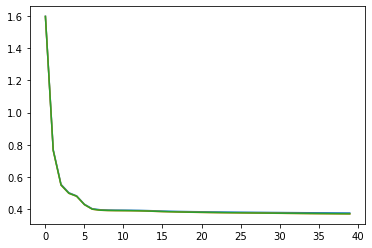

In [22]:
plt.plot(test_rmse_history)
plt.plot(train_rmse_history)
plt.plot(total_rmse_history)

# Original ratings matrix
It's good to look back once in a while

In [23]:
mask * (ratings_dense * a_stds.cpu() + a_avs.cpu())

tensor([[ 8.,  0.,  0.,  ...,  9.,  0.,  0.],
        [ 9.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 9.,  0.,  0.,  ...,  7., 10.,  9.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

# Our predictions
And see how far we've come

In [28]:
mul = torch.matmul(anime_matrix, user_matrix) * a_stds + a_avs
mul

tensor([[8.4565, 9.6004, 8.7436,  ..., 9.1054, 9.0892, 8.9441],
        [8.6836, 9.5547, 8.9600,  ..., 9.2897, 9.0688, 8.9647],
        [7.3027, 8.2903, 7.7658,  ..., 6.2931, 9.0661, 8.9541],
        ...,
        [6.1536, 7.8676, 6.6065,  ..., 5.8541, 8.1039, 7.7327],
        [6.0520, 7.6776, 6.3976,  ..., 5.5897, 8.0784, 7.6384],
        [7.5105, 9.5570, 8.3725,  ..., 7.3307, 9.8271, 9.3888]],
       device='cuda:0', grad_fn=<AddBackward0>)

# Visualization
### Predicted ratings:

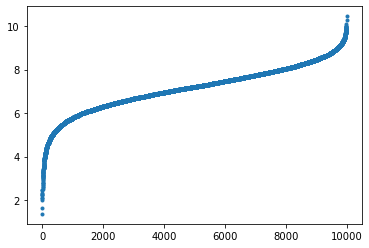

In [29]:
plt.plot(np.sort(np.random.choice(mul.reshape(1,-1).detach().cpu().numpy()[0], 10000)), '.')

Clipping our predictions to lie between 0 and 10 will make it the distribution look pretty similar to the original one. I'm not going to bother though because it makes no difference to the end user.

In [30]:
torch.save(anime_matrix.detach(), os.path.join(directory, 'anime_matrix.pt'))
torch.save(user_matrix.detach(), os.path.join(directory, 'user_matrix.pt'))
torch.save(a_avs, os.path.join(directory, 'a_avs.pt'))
torch.save(a_stds, os.path.join(directory, 'a_stds.pt'))
torch.save(mask, os.path.join(directory, 'mask.pt'))